# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

#!python -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Define transforms
# Training transforms with augmentations
train_transform = transforms.Compose([
                                        transforms.RandomCrop(28, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ColorJitter(brightness=0.45, contrast=0.45, saturation=0.45),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
])

# Test transforms 
test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training and testing datasets
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = train_transform)
test_dataset  = datasets.MNIST(root='./data', train = False, download = True, transform = test_transform)

# Create training set and define training dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

# Create test set and define test dataloader (no shuffle for test data)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

# Preprocessing Justification

#### Augmentation techniques to improve generalization:
- **RandomCrop**: Simulates slight shifts for better alignment.
- **RandomHorizontalFlip**: Adds variability.
- **RandomRotation(10°)**: Accounts for handwriting slants.
- **ColorJitter**: Simulates brightness and contrast variations.
- **ToTensor**: Converts images to tensors.
- **Normalize**: Standardizes pixel values for stable learning.

## Why No Augmentations for Testing?
Only `ToTensor` and `Normalize` are applied to preserve the original test set for fair evaluation.


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


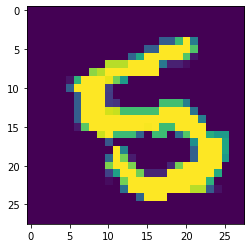

3


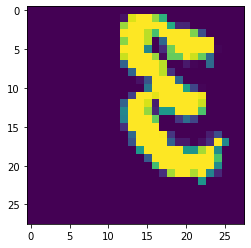

8


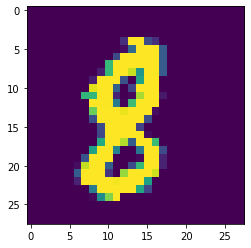

8


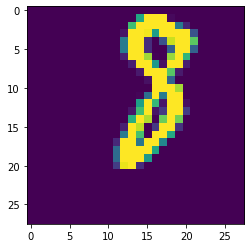

7


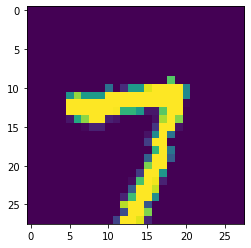

In [4]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class MnistNetwork(nn.Module):
    def __init__(self):
        super(MnistNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1 * 28 * 28, 256)  # Input: 784 pixels (flattened image), Output: 256 neurons
        self.fc2 = nn.Linear(256, 128)  
        self.fc3 = nn.Linear(128, 64)  
        self.fc4 = nn.Linear(64, 10)            # Output layer: 10 neurons for classification

    def forward(self, x):
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  
        x = F.log_softmax(self.fc4(x), dim=1)  # Output layer with log-softmax

        return x

model = MnistNetwork()
model    

MnistNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MnistNetwork().to(device)

# Specify the loss function (Cross-Entropy Loss / multi-class classification)
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
num_epochs     = 10
train_loss     = [] 
train_accuracy = []  

for epoch in range(num_epochs):
    running_loss = 0.0
    correct      = 0
    total        = 0

    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)   # Get inputs and labels (move to device if using GPU)

        # Zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        _, predicted  = torch.max(outputs.data, dim = 1)
        total        += labels.size(0)
        correct      += (predicted == labels).sum().item()

        # Print loss and accuracy every 250 batches
        if i % 250 == 249:  
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/250:.2f}, Accuracy: {100 * correct / total:.2f}%")
            running_loss = 0.0

    # Calculate and store average loss and accuracy per epoch
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    train_accuracy.append(100 * correct / total) 

Epoch [1/10], Step [250/938], Loss: 1.38, Accuracy: 52.48%
Epoch [1/10], Step [500/938], Loss: 0.77, Accuracy: 63.39%
Epoch [1/10], Step [750/938], Loss: 0.63, Accuracy: 68.66%
Epoch [2/10], Step [250/938], Loss: 0.50, Accuracy: 83.47%
Epoch [2/10], Step [500/938], Loss: 0.46, Accuracy: 84.21%
Epoch [2/10], Step [750/938], Loss: 0.43, Accuracy: 84.79%
Epoch [3/10], Step [250/938], Loss: 0.41, Accuracy: 86.68%
Epoch [3/10], Step [500/938], Loss: 0.40, Accuracy: 86.97%
Epoch [3/10], Step [750/938], Loss: 0.35, Accuracy: 87.46%
Epoch [4/10], Step [250/938], Loss: 0.35, Accuracy: 88.74%
Epoch [4/10], Step [500/938], Loss: 0.34, Accuracy: 88.79%
Epoch [4/10], Step [750/938], Loss: 0.32, Accuracy: 89.11%
Epoch [5/10], Step [250/938], Loss: 0.32, Accuracy: 89.89%
Epoch [5/10], Step [500/938], Loss: 0.31, Accuracy: 89.97%
Epoch [5/10], Step [750/938], Loss: 0.30, Accuracy: 90.11%
Epoch [6/10], Step [250/938], Loss: 0.30, Accuracy: 90.73%
Epoch [6/10], Step [500/938], Loss: 0.30, Accuracy: 90.4

In [ ]:
# Plot training loss and accuracy 
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)  # Left subplot for loss
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)  # Right subplot for accuracy
plt.plot(range(len(train_accuracy)), train_accuracy, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
def test_model(model, test_dataloader):
    correct = 0
    total   = 0

    # Set model to evaluation mode (optional)
    model.eval()

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)

            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, dim = 1)

            # Update total and correct predictions
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Test the model
test_model(model, test_loader)

## Saving the model
Using `torch.save`, save your model for future loading.

In [ ]:
# Save the trained model 
model_filename = "JoeEl_MNIST_model.pth"
torch.save(model.state_dict(), model_filename)
print(f"Model saved to: {model_filename}")